# Virtual Tunnel Example Dataset

### 1. Loading of raw dataset 

In [122]:
from loading_routines import load_dataset_super_session

# folder where dataset is located
folder = r'example_dataset\MR42\2019-08-16'

# settings used for extraction of ROIs (neurons), example datasets only contains this combination
iscell_type = 'automatic' 
extraction = 'cellpose'

(settings, 
 trial_table, 
 vr_data, 
 Fcell, 
 FcellNeu, 
 FcellCorr, 
 spikes, 
 pupil_data) = load_dataset_super_session(folder, 
                                          iscell_type=iscell_type, 
                                          extraction=extraction, 
                                          load_pupil=True)


### 2. Data Structure


- settings (dict) : contains mostly settings that were used to run extraction pipeline, but also metadata for experiment 

- trial_table (pd.DataFrame) : contains table of all trials in the dataset with some corresponding metadata (most importantly condition (RUN/MOVIE/REPLAY))

- vr_data (dict) : contains data recorded by virtual environment (each parameter per trial) in ticks (not equally sampled in space)
    - place : place in corridor as defined by wheel movement the mouse ran on
    - flash : ticks when stimuli were flashed
    - reward : tick when reward was presented 
    - reward_mod : which reward was delivered / and was it delivered
    - lick : ticks when licking was detected (not reliable, only works in some sessions)
    - time : time stamp for each tick
    - teleport : tick in which mouse was teleported back to beginning of corridor (optimally also end of trial)
    - ypos : position in the corridor as recorded by virtual environment

- Fcell (np.array) : Raw ca activity of neurons per trial and neurons over time (sampled at ~30Hz)
- FcellNeu (np.array) : same as Fcell but neuropil activity
- FcellCorr (np.array) : same as Fcell but neuropil corrected activity
- spikes (np.array) : same as Fcell but activity in spike "probabilities" (not actualy probabilities but scaled to activity) 
- pupil_data (dict) : position of the pupil (x, y) and radius (r) for each trial




### 2. Remapping 

As activitiy, vr_data and pupil_data have differing sample rates and sample spacing, we resample vr and pupil_data to the activity data and split it into different datasets for each experimental condition

In [136]:
from pre_processing import (split_super_session, 
                            clean_and_resample_place,
                            apply_exclusion, 
                            extend_trial_table,
                            create_signal_data,
                            excluded_trials)

from scipy.signal import resample

split_data = split_super_session(settings, 
                                 trial_table, 
                                 vr_data, 
                                 Fcell, 
                                 FcellNeu, 
                                 FcellCorr, 
                                 spikes, 
                                 pupil_data)                                                      

mapped_data = {}
for exp in split_data.keys():
    
    # exclude trials that show irregularities
    temp_tt = extend_trial_table(split_data[exp]['trial_table'].copy(deep=True), 
                                 split_data[exp]['vr_data'],
                                 split_data[exp]['FcellCorr'], 
                                 conversion_factor=1/1024*64)
    
    temp_tt = excluded_trials(split_data[exp]['vr_data'], 
                              settings, 
                              temp_tt, 
                              threshold_leeway=3, 
                              conversion_factor=1/1024*64, 
                              flash=True)

    (temp_tt, 
    vr_data_ex,
    Fcell_ex, 
    FcellNeu_ex, 
    FcellCorr_ex, 
    spikes_ex,
    pupil_ex) = apply_exclusion(temp_tt, 
                                split_data[exp]['vr_data'],
                                split_data[exp]['Fcell'],
                                split_data[exp]['FcellNeu'], 
                                split_data[exp]['FcellCorr'], 
                                split_data[exp]['spikes'], 
                                settings, 
                                save=False,
                                pupil_data=split_data[exp]['pupil_data'])
                                                
    # match vr_data to activity signal                            
    vr_data_ex = clean_and_resample_place(vr_data_ex)
    signal_data = create_signal_data(vr_data_ex, Fcell_ex, temp_tt)   

    # match pupil data to activity signal
    pupil_x = [resample(pupil, len(Fcell_ex[trial][0])) for trial, pupil in enumerate(pupil_ex['x'])]
    pupil_y = [resample(pupil, len(Fcell_ex[trial][0])) for trial, pupil in enumerate(pupil_ex['y'])]
    pupil_r = [resample(pupil, len(Fcell_ex[trial][0])) for trial, pupil in enumerate(pupil_ex['r'])]
    
    mapped_data[exp] = {}
    mapped_data[exp]['Fcell'] = Fcell_ex
    mapped_data[exp]['FcellNeu'] = FcellNeu_ex
    mapped_data[exp]['FcellCorr'] = FcellCorr_ex
    mapped_data[exp]['spikes'] = spikes_ex
    mapped_data[exp]['vr_data'] = signal_data
    mapped_data[exp]['pupil'] = {'x' : pupil_x, 'y' : pupil_y, 'r' : pupil_r}
    



Trial 53 of 53 resampled.d.

### 3. Visualization

Example visualization of a single cells activity together with position in the corridor and pupil x/y traces for the first 10 trials

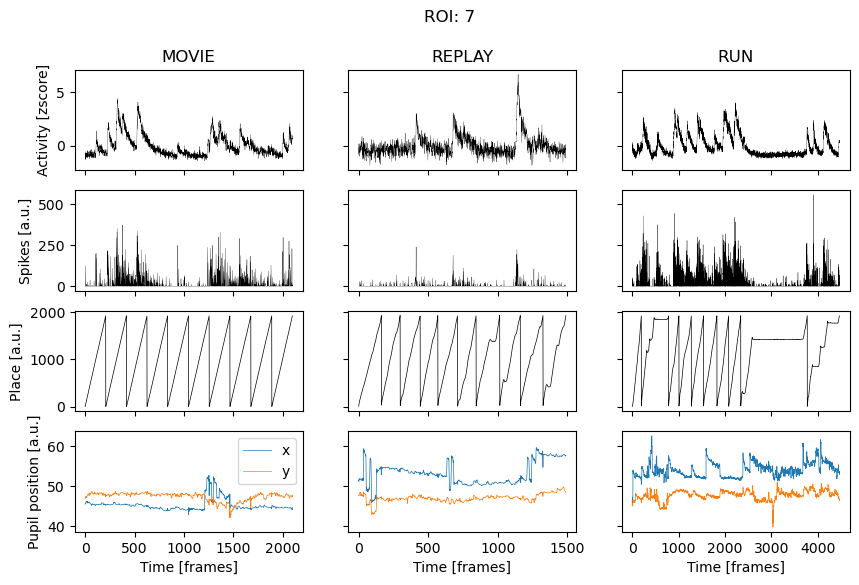

In [140]:
import matplotlib.pyplot as plt
import numpy as np

roi = 7
trials = 10
fig, axs = plt.subplots(ncols=3, nrows=4, sharey='row', sharex='col', figsize=(10,6))
fig.suptitle('ROI: '+str(roi))
for e, exp in enumerate(mapped_data):
    axs[0, e].set_title(exp)
    axs[3, e].set_xlabel('Time [frames]')

    raw_activity = np.concatenate([x[roi] for x in mapped_data[exp]['FcellCorr'][:trials]])
    act_zscore = (raw_activity-np.mean(raw_activity))/np.std(raw_activity)     
    
    axs[0, e].plot(act_zscore,
                   color='k',
                   lw=0.2)

    axs[1, e].plot(np.concatenate([x[roi] for x in mapped_data[exp]['spikes'][:trials]]),
                   color='k',
                   lw=0.2)

    axs[2, e].plot(np.concatenate([x for x in mapped_data[exp]['vr_data']['place'][:trials]]),
                   color='k',
                   lw=0.5)

    axs[3, e].plot(np.concatenate([x for x in mapped_data[exp]['pupil']['x'][:trials]]),
                   color='C0',
                   lw=0.5,
                   label='x')
    
    axs[3, e].plot(np.concatenate([x for x in mapped_data[exp]['pupil']['y'][:trials]]),
                   color='C1',
                   lw=0.5,
                   label='y')
    
    if e == 0:
        axs[0, e].set_ylabel('Activity [zscore]')
        axs[1, e].set_ylabel('Spikes [a.u.]')
        axs[2, e].set_ylabel('Place [a.u.]')
        axs[3, e].set_ylabel('Pupil position [a.u.]')
        axs[3, e].legend()
